### Imports

In [1]:
import torch
import shutil
import pickle

from simulation import citygraph_dataset
from learning import inductive_route_learning, eval_route_generator
from omegaconf import OmegaConf, DictConfig
from hydra import initialize_config_dir, compose
from simulation import drawing

from tqdm import tqdm
from pathlib import Path

### Graph dataset generating

In [2]:
dataset = citygraph_dataset.DynamicCityGraphDataset(
    min_nodes=50,
    max_nodes=50,
    edge_keep_prob=0.7,
    data_type=citygraph_dataset.MIXED,  # or any other type you want
    directed=False,
    fully_connected_demand=True,  # default SIDE_LENGTH_M
    mumford_style=True,
    pos_only=False
)

# Generate graphs
n_graphs = 10  # number of graphs you want to generate
graphs = [dataset.generate_graph(draw=False) for _ in tqdm(range(n_graphs))]



100%|██████████| 10/10 [00:00<00:00, 65.33it/s]


In [3]:
import pickle
from pathlib import Path

# Путь для сохранения
save_path = Path('./output_graphs')
if not save_path.exists():
    save_path.mkdir(parents=True)

# Сохраняем объект в файл
with open(save_path / 'raw_graphs_1000.pkl', 'wb') as ff:
    pickle.dump(graphs, ff)


In [4]:
import pickle

with open(save_path / 'raw_graphs_1000.pkl', 'rb') as f:
    graphs = pickle.load(f)

### Config load and learning construct

In [5]:
from omegaconf import OmegaConf
from hydra import initialize_config_dir, compose

with initialize_config_dir(config_dir="/root/TNDP_learning/cfg", job_name="app"):
    cfg = compose(config_name="ppo_20nodes_copy.yaml")  # загрузит config.yaml + всё из defaults
    # cfg = OmegaConf.to_container(cfg, resolve=False)  # опционально — привести к dict
    print(cfg)

{'ppo': {'n_iterations': 200, 'val_period': 1, 'n_epochs': 1, 'minibatch_size': 128, 'horizon': 120, 'epsilon': 0.2, 'use_gae': True, 'gae_lambda': 0.95}, 'discount_rate': 0.95, 'diff_reward': True, 'baseline_lr': 0.0005, 'entropy_weight': 0.0, 'batch_size': 128, 'reward_scale': 1.0, 'lr': 0.0016134816080499328, 'decay': 0.0008404361781997002, 'optimizer': 'Adam', 'eval': {'n_routes': 10, 'min_route_len': 8, 'max_route_len': 30}, 'dataset': {'type': 'pickle', 'kwargs': {'path': 'output_graphs/mixed', 'space_scale': 0.6, 'demand_scale': 0.2}}, 'experiment': {'logdir': 'training_logs', 'anomaly': False, 'cpu': False, 'seed': 0, 'symmetric_routes': True, 'cost_function': {'type': 'mine', 'kwargs': {'mean_stop_time_s': 0, 'avg_transfer_wait_time_s': 300, 'demand_time_weight': 0.5, 'route_time_weight': 0.5, 'constraint_violation_weight': 5.0, 'variable_weights': True, 'pp_fraction': 0.33, 'op_fraction': 0.33}}}, 'model': {'common': {'dropout': 0.0, 'nonlin_type': 'ReLU', 'embed_dim': 64}, '

/tmp/ipykernel_49994/3755569231.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir="/root/TNDP_learning/cfg", job_name="app"):


In [6]:
cfg

{'ppo': {'n_iterations': 200, 'val_period': 1, 'n_epochs': 1, 'minibatch_size': 128, 'horizon': 120, 'epsilon': 0.2, 'use_gae': True, 'gae_lambda': 0.95}, 'discount_rate': 0.95, 'diff_reward': True, 'baseline_lr': 0.0005, 'entropy_weight': 0.0, 'batch_size': 128, 'reward_scale': 1.0, 'lr': 0.0016134816080499328, 'decay': 0.0008404361781997002, 'optimizer': 'Adam', 'eval': {'n_routes': 10, 'min_route_len': 8, 'max_route_len': 30}, 'dataset': {'type': 'pickle', 'kwargs': {'path': 'output_graphs/mixed', 'space_scale': 0.6, 'demand_scale': 0.2}}, 'experiment': {'logdir': 'training_logs', 'anomaly': False, 'cpu': False, 'seed': 0, 'symmetric_routes': True, 'cost_function': {'type': 'mine', 'kwargs': {'mean_stop_time_s': 0, 'avg_transfer_wait_time_s': 300, 'demand_time_weight': 0.5, 'route_time_weight': 0.5, 'constraint_violation_weight': 5.0, 'variable_weights': True, 'pp_fraction': 0.33, 'op_fraction': 0.33}}}, 'model': {'common': {'dropout': 0.0, 'nonlin_type': 'ReLU', 'embed_dim': 64}, '

In [ ]:
inductive_route_learning.setup_and_train(cfg)

  0%|          | 0/200 [00:00<?, ?it/s]

 33%|███▎      | 66/200 [50:36<2:17:48, 61.71s/it]

### Evaluation 

In [ ]:
with initialize_config_dir(config_dir="/root/TNDP_learning/cfg", job_name="app"):
    cfg = compose(config_name="ppo_20nodes_copy.yaml",
                  overrides=[
                      "++model.weights=/root/TNDP_learning/output/inductive_gae_seed_1.pt",
                      "++eval.dataset.path=/root/TNDP_learning/CEC2013Supp/Instances",
                      "+eval=mandl",
                      "+run_name=my_mandl_lc100_2"
                  ])

/tmp/ipykernel_10065/2823666616.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir="/root/TNDP_learning/cfg", job_name="app"):


In [ ]:
cfg

{'experiment': {'logdir': None, 'anomaly': False, 'cpu': False, 'seed': 0, 'symmetric_routes': True, 'cost_function': {'type': 'mine', 'kwargs': {'mean_stop_time_s': 0, 'avg_transfer_wait_time_s': 300, 'demand_time_weight': 0.5, 'route_time_weight': 0.5, 'constraint_violation_weight': 5.0, 'variable_weights': True, 'pp_fraction': 0.33, 'op_fraction': 0.33}}}, 'model': {'common': {'dropout': 0.0, 'nonlin_type': 'ReLU', 'embed_dim': 64}, 'route_generator': {'kwargs': {'force_linking_unlinked': False, 'logit_clip': None, 'n_nodepair_layers': 3, 'n_pathscorer_layers': 3, 'pathscorer_hidden_dim': 16, 'n_halt_layers': 3, 'halt_scorer_type': 'endpoints', 'serial_halting': True}, 'type': 'PathCombiningRouteGenerator'}, 'backbone_gn': {'net_type': 'graph attn', 'kwargs': {'n_layers': 5, 'in_node_dim': 4, 'in_edge_dim': 13, 'use_norm': False, 'n_heads': 4, 'dense': False}}, 'weights': '/root/TNDP_learning/output/op.pt'}, 'n_samples': 100, 'batch_size': 512, 'eval': {'csv': True, 'dataset': {'typ

In [ ]:
DEVICE, run_name, _, cost_obj, model = eval_route_generator.lrnu.process_standard_experiment_cfg(
    cfg, 'nn_construction_', weights_required=True
)

test_ds = eval_route_generator.get_dataset_from_config(cfg.eval.dataset)
test_dl = eval_route_generator.DataLoader(test_ds, batch_size=cfg.batch_size)

n_samples = cfg.get('n_samples', None)
sbs = cfg.get('sample_batch_size', cfg.batch_size)
_, _, routes = eval_route_generator.eval_model(
    model, test_dl, cfg.eval, cost_obj,
    n_samples=n_samples, sample_batch_size=sbs, return_routes=True,
    device=DEVICE
)

eval_route_generator.dump_routes(run_name, routes.cpu())

100%|██████████| 1/1 [00:00<00:00, -1.90it/s]

,6.000,0.556,13.394,140.000,59.216,36.802,3.918,0.064,0.000,0.000,-0.530,0.000


In [ ]:
with open("/root/TNDP_learning/output_routes/nn_construction_my_mandl_lc100_2_routes.pkl", "rb") as f:
    routes = pickle.load(f)

In [ ]:
routes

[tensor([[10,  9,  7,  5,  2,  1,  0],
         [ 6, 14,  5,  3,  4, -1, -1],
         [13, 12, 10, 11, -1, -1, -1],
         [14,  8, -1, -1, -1, -1, -1],
         [12, 13, -1, -1, -1, -1, -1],
         [ 7, 14, -1, -1, -1, -1, -1]])]

In [ ]:
import torch

node_locs = []
with open("/root/TNDP_learning/CEC2013Supp/Instances/MandlCoords.txt") as f:
    lines = f.readlines()
    # Пропускаем первую строку (число узлов)
    for line in lines[1:]:
        parts = line.strip().split()
        if len(parts) == 2:
            x, y = float(parts[0]), float(parts[1])
            node_locs.append([x, y])
node_locs = torch.tensor(node_locs, dtype=torch.float)
print(node_locs.shape)  # Должно быть (15, 2)

torch.Size([15, 2])


In [ ]:
graph = torch.load("/root/TNDP_learning/output_graphs/mixed/processed/pre_transform.pt")

In [ ]:
type(graph)

str

In [ ]:
node_locs = graph[1]['stop']['pos']
print(node_locs.shape)

TypeError: string indices must be integers

In [ ]:
print(type(routes))
print(len(routes))
print(routes[0].shape)
print(routes[0])

<class 'list'>
1
torch.Size([6, 7])
tensor([[10,  9,  7,  5,  2,  1,  0],
        [ 6, 14,  5,  3,  4, -1, -1],
        [13, 12, 10, 11, -1, -1, -1],
        [14,  8, -1, -1, -1, -1, -1],
        [12, 13, -1, -1, -1, -1, -1],
        [ 7, 14, -1, -1, -1, -1, -1]])


In [ ]:
routes_tensor = routes[0]  # если routes — список из одного элемента
routes_list = []
for row in routes_tensor:
    route = row[row != -1]  # убираем паддинги
    routes_list.append(route)

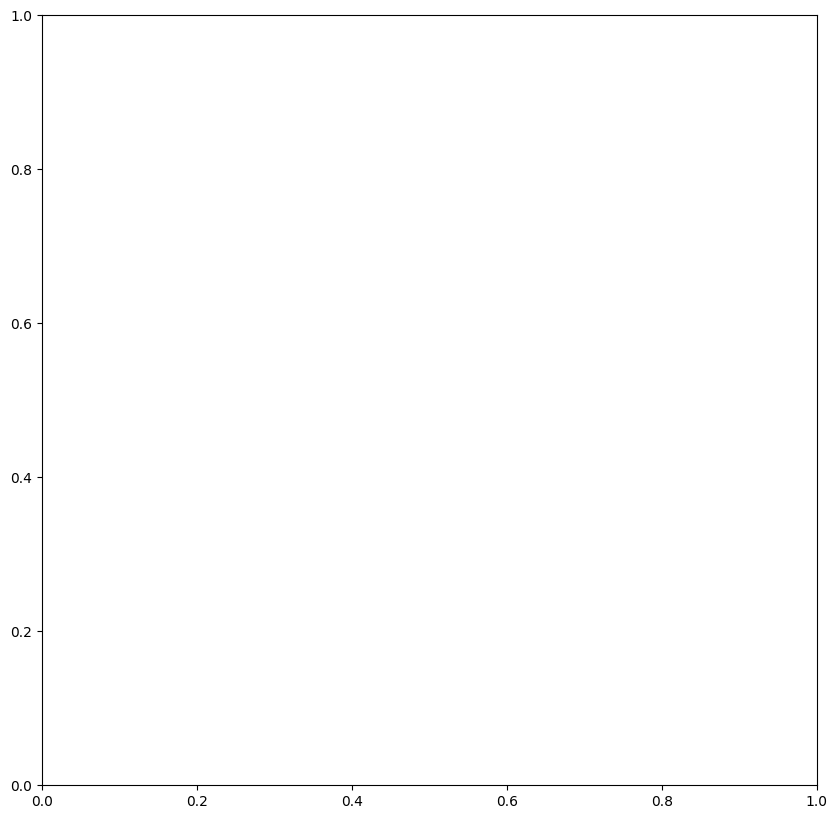

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))

In [ ]:
!python 'learning/eval_route_generator.py' --help 

eval_route_generator is powered by Hydra.

== Configuration groups ==
Compose your configuration from those groups (group=option)

eval: laval, lavalDA, mandl, mumford, mumford0, mumford1, mumford2, mumford3, vo
experiment: standard
experiment/cost_function: mine, multi, nikolic, op, pp
init: john, load, nikolic
model: bestsofar_feb2023, newmodel, noextra, optimal_jan2022, random_path_combiner
model/route_generator: biased, nodewalker, unbiased
online_planner: bco, neural, neural_bco


== Config ==
Override anything in the config (foo.bar=value)

experiment:
  logdir: null
  anomaly: false
  cpu: false
  seed: 0
  symmetric_routes: true
  cost_function:
    type: mine
    kwargs:
      mean_stop_time_s: 0
      avg_transfer_wait_time_s: 300
      demand_time_weight: 0.5
      route_time_weight: 0.5
      constraint_violation_weight: 5.0
      variable_weights: true
      pp_fraction: 0.33
      op_fraction: 0.33
model:
  common:
    dropout: 0.0
    nonlin_type: ReLU
    embed_dim: 64


In [ ]:
config = {
    'experiment': {
        'logdir': None,
        'anomaly': False,
        'cpu': False,
        'seed': 0,
        'symmetric_routes': True,
        'cost_function': {
            'type': 'mine',
            'kwargs': {
                'mean_stop_time_s': 0,
                'avg_transfer_wait_time_s': 300,
                'demand_time_weight': 0.5,
                'route_time_weight': 0.5,
                'constraint_violation_weight': 5.0,
                'variable_weights': True,
                'pp_fraction': 0.33,
                'op_fraction': 0.33
            }
        }
    },
    'model': {
        'common': {
            'dropout': 0.0,
            'nonlin_type': 'ReLU',
            'embed_dim': 64
        },
        'route_generator': {
            'type': 'PathCombiningRouteGenerator',
            'kwargs': {
                'force_linking_unlinked': False,
                'logit_clip': None,
                'n_nodepair_layers': 3,
                'n_pathscorer_layers': 3,
                'pathscorer_hidden_dim': 16,
                'n_halt_layers': 3,
                'halt_scorer_type': 'endpoints',
                'serial_halting': True
            }
        },
        'backbone_gn': {
            'net_type': 'graph attn',
            'kwargs': {
                'n_layers': 5,
                'in_node_dim': 4,
                'in_edge_dim': 13,
                'use_norm': False,
                'n_heads': 4,
                'dense': False
            }
        },
        'weights': '/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/output/inductive_30_06_2025_18_12_45.pt'
    },
    'n_samples': 100,
    'batch_size': 512,
    'eval': {
        'csv': True,
        'n_routes': 6,
        'min_route_len': 2,
        'max_route_len': 8,
        'dataset': {
            'type': 'mumford',
            'path': '/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/CEC2013Supp-2/Instances',
            'city': 'Mandl'
        }
    },
    'run_name': 'my_mandl_lc100_2'
}

### Бэнчмарк граф 

In [ ]:
!python 'learning/eval_route_generator.py' +model.weights=/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/output/inductive_30_06_2025_18_12_45.pt \
    eval.dataset.path=/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/datasets/mumford_dataset/Instances \
    +eval=mandl +run_name=mandl_lc100_test

[2025-07-14 17:45:33,989][root][INFO] - seed is 0
[2025-07-14 17:45:33,989][root][INFO] - device is cpu
[2025-07-14 17:45:34,011][root][INFO] - Estimated meters per unit: 2347.21533203125
[2025-07-14 17:45:34,012][root][INFO] - Environment side length: 18777.72265625 meters
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]
,6.000,0.759,11.745,230.000,74.181,25.819,0.000,0.000,0.000,0.000,1.013,0.000


In [ ]:
!python -m scripts.data_display.plot_generated_networks cfg/eval/mandl.yaml \
    --routes output_routes/neural_bco_14_07_2025_17:58:20_routes.pkl \
    -o plots/mandl_routes_test_neural_bco.png

In [ ]:
!python learning/bee_colony.py eval.dataset.path=/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/datasets/mumford_dataset/Instances \
    +eval=mandl \
    init.path=output_routes/nn_construction_mandl_lc100_test_routes.pkl

[2025-07-14 17:54:37,656][root][INFO] - seed is 0
[2025-07-14 17:54:37,656][root][INFO] - device is cpu
[2025-07-14 17:54:37,674][root][INFO] - Estimated meters per unit: 2347.21533203125
[2025-07-14 17:54:37,675][root][INFO] - Environment side length: 18777.72265625 meters
100%|█████████████████████████████████████████████| 1/1 [00:31<00:00, 31.97s/it]
,6.000,0.558,13.493,140.000,59.216,36.609,4.110,0.064,0.000,0.000,31.971,401.000


In [ ]:
!python learning/bee_colony.py -h

In [ ]:
!python learning/bee_colony.py --config-name neural_bco_mumford \
    +model.weights=/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/output/inductive_30_06_2025_18_12_45.pt \
    eval.dataset.path=/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/datasets/mumford_dataset/Instances \
    +eval=mandl \
    init.path=output_routes/nn_construction_mandl_lc100_test_routes.pkl \
    >> bco_test_pareto.csv

100%|████████████████████████████████████████████| 1/1 [02:25<00:00, 145.94s/it]


### Vaska

In [ ]:
!python 'learning/eval_route_generator.py' +model.weights=/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/output/inductive_30_06_2025_18_12_45.pt \
    eval.dataset.path=/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/datasets/vo_dataset \
    +eval=VO +run_name=vo_test \
    n_samples=100 


[2025-07-15 15:22:01,436][root][INFO] - seed is 0
[2025-07-15 15:22:01,436][root][INFO] - device is cpu
100%|█████████████████████████████████████████████| 1/1 [01:19<00:00, 79.05s/it]
,10.000,1.835,14.864,348.200,24.933,51.108,14.456,9.503,522.500,0.000,79.040,0.000


In [ ]:
!python learning/bee_colony.py eval.dataset.path=/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/datasets/vo_dataset \
    +eval=VO \
    init.path=output_routes/nn_construction_vo_test_routes.pkl

[2025-07-15 15:27:32,778][root][INFO] - seed is 0
[2025-07-15 15:27:32,778][root][INFO] - device is cpu
100%|███████████████████████████████████████████| 1/1 [25:43<00:00, 1543.11s/it]
,10.000,1.502,15.810,333.960,23.149,50.968,22.791,3.092,212.000,0.000,1543.110,401.000


In [ ]:
!python learning/bee_colony.py --config-name neural_bco_mumford \
    +model.weights=/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/output/inductive_30_06_2025_18_12_45.pt \
    eval.dataset.path=/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/datasets/vo_dataset \
    +eval=VO \
    init.path=output_routes/nn_construction_vo_test_routes.pkl 

[2025-07-15 16:10:08,112][root][INFO] - seed is 0
[2025-07-15 16:10:08,112][root][INFO] - device is cpu
100%|█████████████████████████████████████████| 1/1 [1:32:07<00:00, 5527.17s/it]
,10.000,1.607,15.412,331.040,23.623,51.320,18.706,6.351,316.500,0.000,5527.161,401.000


In [ ]:
!python 'learning/eval_route_generator.py' -h

In [ ]:
!python -m scripts.data_display.plot_generated_networks --help

In [ ]:
!python -m scripts.data_display.plot_generated_networks cfg/eval/mandl.yaml \
    --routes output_routes/.pkl \
    -o plots/mandl_routes.png

edge (1, 2) has 2 routes
edge (2, 5) has 2 routes
edge (3, 5) has 2 routes
edge (5, 14) has 2 routes
edge (6, 14) has 2 routes
edge (8, 14) has 2 routes


In [ ]:
!python -m scripts.data_display.plot_generated_networks cfg/eval/vo.yaml \
    --routes output_routes/neural_bco_15_07_2025_16:10:08_routes.pkl \
    -o plots/vo_routes_test_bco_neural.png

edge (1, 9) has 2 routes
edge (9, 11) has 2 routes
edge (11, 14) has 2 routes
edge (12, 14) has 2 routes
edge (59, 84) has 2 routes
edge (83, 84) has 2 routes
edge (83, 104) has 3 routes
edge (97, 101) has 2 routes
edge (92, 97) has 2 routes
edge (94, 98) has 2 routes
edge (78, 94) has 2 routes
edge (75, 78) has 2 routes
edge (74, 75) has 2 routes
edge (72, 73) has 2 routes
edge (7, 30) has 2 routes
edge (29, 30) has 2 routes
edge (53, 54) has 2 routes
edge (28, 53) has 2 routes
edge (28, 29) has 3 routes
edge (2, 29) has 2 routes
edge (2, 31) has 2 routes


In [ ]:
!python -m scripts.data_display.plot_pareto \
    VO_pareto.csv \
    -o pareto.png

Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.9/3.9.23/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/homebrew/Cellar/python@3.9/3.9.23/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/scripts/data_display/plot_pareto.py", line 217, in <module>
    main()
  File "/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/scripts/data_display/plot_pareto.py", line 208, in main
    unified_df = pu.aggregate_and_preprocess_data(args.data, args.asymmetric)
  File "/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/plotting_utils.py", line 149, in aggregate_and_preprocess_data
    df = pd.read_csv(path, header=0)
  File "/Users/sashamorozov/Documents/Code/GNN/TNDP_learning/.venv/lib/python3.9/site-packages/pandas/io/parsers/readers.